In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
data = pd.read_csv('restaurant.csv')


# Data Cleansing


In [7]:
#drop below columns, as these info is free text type of data, which is unlikely to carry impactful info
new_data = data.drop(['_id', 'address', 'label', 'phone', 'restauranLink', 'restaurantName' ], axis = 1)

#convert ranking to numeric value for later PCA analysis
new_data['ranking'] = new_data['ranking'].str.split(' ', n=1, expand=True)[0].str.replace('#', '').str.replace(',' ,'')


#------------------------ Special Justification ---------------------------------------------------
#These 3 columns are a bit special, they are text based, but they seem contain categorical info. 
# I suspect that there could be cases that restaurants has more specific cuisine, e.g: American, or special service, 
# e.g: bar, could attract more good ratings, but specialized restaurant could be in dis-advantage as they have less
#services, due to this reason, I decided to convert the 3 columns into categorical columns, which will significantly 
#increase the total number of features.

new_data = new_data.join(new_data['cuisine'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['openMeal'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['region'].str.replace(' ', '').str.get_dummies(sep=',').add_prefix('region_'))

#drop text based data as it has been converted to numeric representation
new_data.drop(labels=['cuisine', 'openMeal', 'region'], axis=1,inplace = True)

#conver the $ to numeric value
def convert(col):
    col = str(col)
    if col == '$$$$':
        return  4
    elif col == '$$ - $$$':
        return 2.5
    elif col == '$$$':
        return 3
    elif col == '$$':
        return 2
    elif col == '$':
        return 1
    else:
        return 2.5

new_data['ratingAndPopularity'] = new_data['ratingAndPopularity'].apply(convert)

#------------------------ Special Justification ---------------------------------------------------
# Drop these columns: numbeOfReviews,numberAverage,numberExcellent,numberPoor,numberTerrible,numberVeryGood
# This is due to there are percentage based columns which deliver the same message:
# ratingAverage,ratingExcellent,ratingPoor,ratingTerrible,ratingVeryGood which is more meaningful than counts,
# As a new restaurant definitely has less number of counts than existing, but it could be a good restaurant
new_data.drop(labels=['numbeOfReviews', 'numberAverage', 'numberExcellent', 'numberPoor', 'numberTerrible', 'numberVeryGood'], axis=1,inplace = True)

#convert percentage string to float
new_data['ratingAverage'] = new_data['ratingAverage'].str.rstrip('%').astype('float') / 100.0
new_data['ratingExcellent'] = new_data['ratingExcellent'].str.rstrip('%').astype('float') / 100.0
new_data['ratingPoor'] = new_data['ratingPoor'].str.rstrip('%').astype('float') / 100.0
new_data['ratingTerrible'] = new_data['ratingTerrible'].str.rstrip('%').astype('float') / 100.0
new_data['ratingVeryGood'] = new_data['ratingVeryGood'].str.rstrip('%').astype('float') / 100.0

print(new_data.head())


   Atmosphere  Food  Service  Value ranking  ratingAndPopularity  \
0         4.5   4.5      4.5    4.0      31                  2.5   
1         4.5   4.5      4.5    4.0      32                  4.0   
2         4.0   4.5      4.0    4.5      33                  2.5   
3         4.5   4.5      4.5    4.0      34                  2.5   
4         NaN   4.0      4.5    4.5      35                  2.5   

   ratingAverage  ratingExcellent  ratingPoor  ratingTerrible  ...  \
0           0.06             0.58        0.02            0.01  ...   
1           0.09             0.57        0.02            0.01  ...   
2           0.08             0.57        0.02            0.01  ...   
3           0.07             0.55        0.03            0.02  ...   
4           0.03             0.87        0.00            0.00  ...   

   region_Sushi  region_Swedish  region_Swiss  region_Taiwanese  region_Thai  \
0             0               0             0                 0            0   
1         

# Deal with Missing Data and Standardize

In [8]:
null_columns=new_data.columns[new_data.isnull().any()]
print(new_data[null_columns].isnull().sum())

from sklearn.preprocessing import Imputer
values = new_data.values
#Use median instead of mean, as mean may not represent most of the data and is greatly impacted by the outliners.
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
new_value = imputer.fit_transform(values)
new_data = pd.DataFrame(new_value)
sumry = new_data.describe().transpose()
print("Summary Statistics:\n",sumry,'\n')

data_std = StandardScaler().fit_transform(new_data)


Atmosphere         144
totalPageNumber     12
dtype: int64
Summary Statistics:
       count        mean         std    min     25%     50%     75%      max
0    1230.0    3.944715    0.429051   2.00    3.50    4.00    4.00     5.00
1    1230.0    4.174797    0.329483   3.00    4.00    4.00    4.50     5.00
2    1230.0    4.016667    0.397212   2.50    4.00    4.00    4.50     5.00
3    1230.0    3.843496    0.389679   2.50    3.50    4.00    4.00     5.00
4    1230.0  649.287805  360.074224  31.00  338.25  648.00  955.00  1449.00
5    1230.0    2.536585    0.735231   1.00    2.50    2.50    2.50     4.00
6    1230.0    0.130211    0.064051   0.00    0.08    0.13    0.17     0.42
7    1230.0    0.413276    0.153388   0.06    0.29    0.39    0.51     0.98
8    1230.0    0.034740    0.028423   0.00    0.01    0.03    0.05     0.19
9    1230.0    0.023065    0.022340   0.00    0.00    0.02    0.03     0.18
10   1230.0    4.114228    0.293267   3.50    4.00    4.00    4.50     5.00
11   123

c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Run PCA


In [19]:
features = list(new_data)
colnames = np.transpose(features)

n_components = len(features)
pca = PCA(n_components).fit(data_std)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_

# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
print('Loading Matrix:'); loadings= np.sqrt(eigval)*eigvec
print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 45 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')


Loading Matrix:
          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.455007 -0.311778 -0.021255 -0.071909  0.154475  0.046497 -0.087307   
1    0.403988 -0.264545  0.529208 -0.290279 -0.081148  0.096853 -0.021065   
2    0.564669 -0.366173  0.227206 -0.267328  0.035795  0.031943 -0.047514   
3    0.253082 -0.160774  0.519272 -0.238141 -0.033140  0.125099 -0.135677   
4   -0.322229  0.189796 -0.263049 -0.357795 -0.251846  0.181026 -0.097660   
5    0.326084 -0.252320 -0.094888 -0.114959  0.009475 -0.164964  0.180367   
6   -0.488666  0.316062 -0.411970  0.206407 -0.045139 -0.077182  0.022352   
7    0.637403 -0.400738  0.395743 -0.250725  0.085373  0.035211 -0.048354   
8   -0.178605  0.128475 -0.439326  0.302893 -0.055217 -0.051239  0.152158   
9   -0.174190  0.106359 -0.360840  0.325132 -0.034553 -0.042792  0.148912   
10   0.532082 -0.327336  0.422617 -0.356071  0.059121  0.087917 -0.107926   
11  -0.524671  0.321145 -0.125616  0.085451 -0.071741  0.017

# Plot


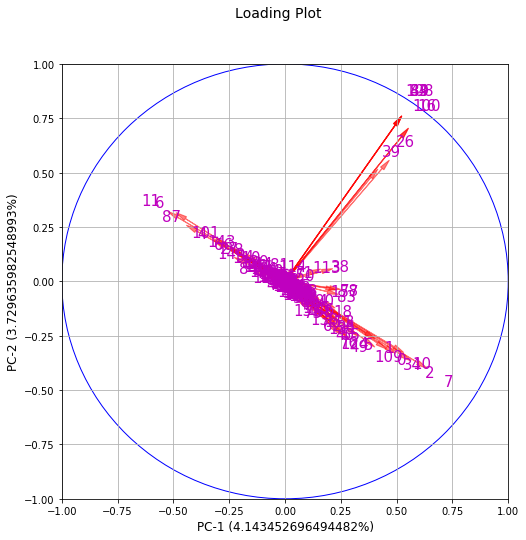

In [16]:
# (8) Loadings Plot
coeff = loadings[:,0:2]
fig = plt.figure(figsize=(8,8))
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.suptitle('Loading Plot',fontsize=14)
plt.xlabel('PC-1 ('+str(var_expln[0])+'%)',fontsize=12)
plt.ylabel('PC-2 ('+str(var_expln[1])+'%)',fontsize=12)

for i in range(len(coeff[:,0])):
    plt.arrow(0,0,coeff[i,0],coeff[i,1],color='r',
              alpha=0.5,head_width=0.02, head_length=0.05,length_includes_head=True)
    plt.text(coeff[i,0]*1.15,coeff[i,1]*1.15,features[i],fontsize=15,
             color='m',ha='center',va='center')

circle = plt.Circle((0, 0), 0.9999999,  color='b', fill=False)
ax = fig.gca(); ax.add_artist(circle)
plt.grid(); plt.show()


# Scree plot


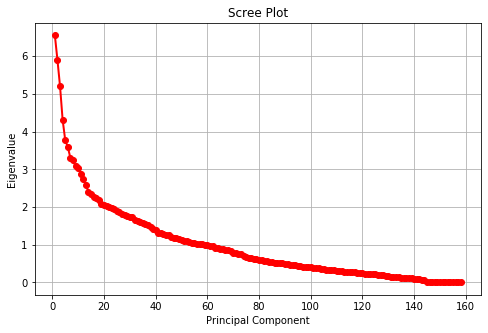

In [13]:
num_vars= len(features)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(); plt.show()


# Analysis of earlier hypnosis: The type of restaurant style or services have impact


In [ ]:
# The plot shows that the is no significant drop of Eigenvalues after first a few principle components
